In [98]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

In [22]:
p_pheno = '/home/harveyaa/Documents/fMRI/data/ukbb_9cohorts/pheno_26-01-22.csv'
p_conn = '/home/harveyaa/Documents/fMRI/data/ukbb_9cohorts/connectomes_01-12-21.csv'

pheno = pd.read_csv(p_pheno,index_col=0)
conn = pd.read_csv(p_conn,index_col=0)

/home/harveyaa/miniconda3/envs/MTL/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3457: DtypeWarning: Columns (7,8,12,13,14,19,20,24,27,31,42,43,44,49,51,59,60,62,64,65,68,101,121,163) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [23]:
cases = ['SZ',
        'ASD',
        'BIP',
        'DEL22q11_2',
        'DUP22q11_2',
        'DEL16p11_2',
        'DUP16p11_2',
        'DEL1q21_1',
        'DUP1q21_1']

conf = ['AGE',
        'SEX',
        'SITE',
        'mean_conn',
        'FD_scrubbed']

In [99]:
p_ids = '/home/harveyaa/Documents/masters/MTL/conf_balancing/dataset_ids'

#clf = SVC(C=100)
#clf = SVC(C=10)
#clf = SVC(C=1)
#clf = LogisticRegression()
clf = KNeighborsClassifier()

mean_acc_conf = []
mean_acc_conn = []
for case in cases:
    print(case)
    dataset_ids = pd.read_csv(os.path.join(p_ids,f"{case}.txt"),header=None)[0].to_list()
    df = pheno[pheno.index.isin(dataset_ids)]

    X = pd.get_dummies(df[conf],columns=['SEX','SITE'],drop_first=True)
    X_conn = conn[conn.index.isin(dataset_ids)]
    y = df[case]

    acc_conf = []
    acc_conn = []
    acc_both = []

    n_folds = 0
    for i in range(5):
        if os.path.exists(os.path.join(p_ids,f"{case}_test_set_{i}.txt")):
            # LOAD IDS
            fold_test_ids = pd.read_csv(os.path.join(p_ids,f"{case}_test_set_{i}.txt"),header=None)[0].to_list()
            test_mask = df.index.isin(fold_test_ids)

            # TRAIN/TEST SPLIT
            X_train, X_test = X[~test_mask], X[test_mask]
            X_conn_train, X_conn_test = X_conn[~test_mask], X_conn[test_mask]
            y_train, y_test = y[~test_mask], y[test_mask]

            
            # PRED FROM CONFOUNDS
            clf.fit(X_train,y_train)
            pred = clf.predict(X_test)
            acc_conf.append(accuracy_score(y_test,pred))

            # PRED FROM CONNECTOMES
            clf.fit(X_conn_train,y_train)
            pred_conn = clf.predict(X_conn_test)
            acc_conn.append(accuracy_score(y_test,pred_conn))
            n_folds +=1

    mean_acc_conf.append(np.mean(acc_conf))
    mean_acc_conn.append(np.mean(acc_conn))
    print('N folds: ',n_folds)
    #print('Chance level: ',np.sum(y_test)/len(y_test))
    print('Mean acc conf: ', np.mean(acc_conf))
    print('Mean acc conn: ', np.mean(acc_conn))
    print()

SZ
N folds:  5
Mean acc conf:  0.5255835018537244
Mean acc conn:  0.549698769801146

ASD
N folds:  5
Mean acc conf:  0.49822960597327004
Mean acc conn:  0.5342253421246634

BIP
N folds:  5
Mean acc conf:  0.5146543778801843
Mean acc conn:  0.5060829493087557

DEL22q11_2
N folds:  5
Mean acc conf:  0.532
Mean acc conn:  0.54

DUP22q11_2
N folds:  5
Mean acc conf:  0.5111111111111111
Mean acc conn:  0.5444444444444445

DEL16p11_2
N folds:  5
Mean acc conf:  0.5005494505494505
Mean acc conn:  0.6545329670329669

DUP16p11_2
N folds:  5
Mean acc conf:  0.5
Mean acc conn:  0.50625

DEL1q21_1
N folds:  5
Mean acc conf:  0.5181818181818182
Mean acc conn:  0.5863636363636364

DUP1q21_1
N folds:  4
Mean acc conf:  0.53125
Mean acc conn:  0.4609375



In [100]:
results = pd.DataFrame([mean_acc_conf,mean_acc_conn],columns=cases,index=['conf','conn']).transpose()
results

,conf,conn
SZ,0.525584,0.549699
ASD,0.498230,0.534225
BIP,0.514654,0.506083
DEL22q11_2,0.532000,0.540000
DUP22q11_2,0.511111,0.544444
DEL16p11_2,0.500549,0.654533
DUP16p11_2,0.500000,0.506250
DEL1q21_1,0.518182,0.586364
DUP1q21_1,0.531250,0.460938


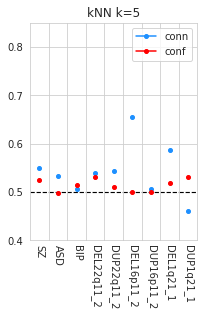

In [101]:
fig,ax = plt.subplots(1,len(cases),figsize=(3,4),sharey=True,sharex=True)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1])
plt.ylim(0,1)
sns.set_style('whitegrid')

for j,case in enumerate(cases):
    conf_acc = results.loc[case,'conf']
    conn_acc = results.loc[case,'conn']

    #if conf_acc > conn_acc:
    #    mfc = 'white'
    #    ls =''
    #else:
    #    mfc = 'dodgerblue'
    #    ls = '-'
    #ax[j].plot(0,conn_acc,marker='o',color='dodgerblue',ms=4,markerfacecolor=mfc)
    #ax[j].plot(0,conf_acc,marker='o',color='dodgerblue',ms=4,markerfacecolor=mfc)
    ax[j].plot(0,conn_acc,marker='o',color='dodgerblue',ms=4,markerfacecolor='dodgerblue',label='conn')
    ax[j].plot(0,conf_acc,marker='o',color='red',ms=4,markerfacecolor='red',label='conf')

    #ax[j].plot((0,0),(conf,conn),color='dodgerblue',ls=ls)

    ax[j].set_xticklabels([])
    ax[j].set_xticks([])
    ax[j].set_xlim(-0.1,0.1)
    ax[j].set_ylim(0.4,0.85)

    ax[j].set_xlabel(case,rotation=270)

    lines = ax[j].get_ygridlines()
    b = lines[5]
    b.set_color('black')
    b.set_linewidth(1.15)
    b.set_linestyle('--')
    fig.subplots_adjust(wspace=0)

ax[4].set_title('kNN k=5')
plt.legend()
#plt.tight_layout()
#plt.savefig('/home/harveyaa/Documents/masters/MTL/results/courtois_meeting/tasks_9/run1.png',dpi=300)